## part 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
image = np.loadtxt('zipcombo.dat')
data_1 = np.loadtxt('dtrain123.dat')


# extracting image and labels

y = image[:,0].astype(int)
x = image[:, 1:]

the labels are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
the number of labels is 9298
the size of pixels is 16


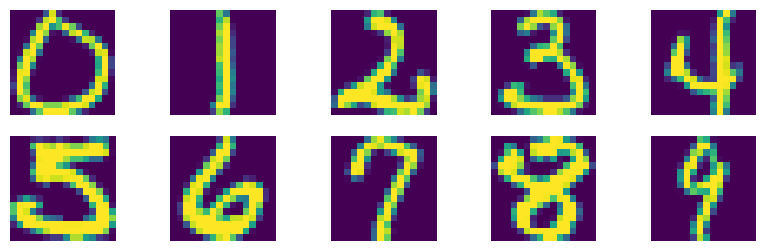

In [2]:
# data understanding 
label = list(set(y))
print("the labels are",label)
print("the number of labels is",len(y))
print("the size of pixels is", int(np.sqrt(np.shape(x)[1])))

# generating sample images:
plt.figure(figsize=(10,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    # size 256
    plt.imshow(x[np.argwhere(y==i)[0],:].reshape(16,16)) 
    plt.axis('off')

#### training function

In [82]:
max_iter = 30
min_iter = 6

# Adding a kernel with dimension as the input 
def Kd(xm, xn, d):
    '''return the polynomial kernel matrix which is parameterized by a positive integer d
    controlling the dimension of the polynomial.'''
    return (xm @ xn.T)**d

#==================================================================================================

# one-versus-rest:
def OvR(X, y, d, kernel):
    '''
    input X - images pixel
    input y - label
    input d - dimension of kernel
    inpur kernel - kernel function
    return w as updated classifier, accuracy as the prediction accuracy
    '''
    # kernel 
    k = kernel(X, X, d)
    
    # the no.of mistakes 
    mistake = 0
    accuracy= []
    # initial classifier w
    w = np.zeros((10, X.shape[0])) # 10 classes

    # training loop:
    for n in range(1,max_iter):
        randomI= list(range(X.shape[0]))
        np.random.shuffle(randomI) # random sequence of indices

        # count mistake and rewrite w
        for i in randomI:
            # predict y
            y_pred = np.argmax(w @ k[i,:])
            # if prediction is not the same as true label
            if y[i] != y_pred:
                mistake +=1
                w[int(y[i]), i] +=1   # update by +1
                w[int(y_pred), i] -=1      # update by -1
        
        accuracy.append((n-mistake)/n)    # training accuracy based on number of iteration
        mistake = 0 # initial no. of mistake for new iteration
        
        #convergence:
        if (n >= min_iter) and (accuracy[-1]-accuracy[-2]<0.001):
            break
        else:
            continue

    return w, accuracy

#==================================================================================================


# choose two of ten classes and combine them as a group
binary_group = list(itertools.combinations(range(10),2)) # k(k − 1)/2 

# defining a voting scheme to produce prediction
def voting(product):
    vote_n = np.zeros(10)                        
    vote = int(((np.sign(product)+2)//2)).tolist() 
    for i,j in enumerate(vote):
        vote_n[binary_group[i][j]] +=1       
    return np.argmax(vote_n)                     


# one-versus-one

def OvO(X, y, d, kernel):
    '''
    input X - images pixel
    input y - label
    input d - dimension of kernel
    inpur kernel - kernel function
    return w as updated classifier, accuracy as the prediction accuracy
    '''
    #kernel
    k = kernel(X, X, d)
    #initialisation
    w = np.zeros((10*9/2, X.shape[0])) # k(k − 1)/2 
    mistake = 0
    accuracy= []

    for n in range(1,max_iter):
        randomI= list(range(X.shape[0]))
        np.random.shuffle(randomI) 
        
        for i in randomI:
            product = w @ kernel[i,:]
            y_pred= voting(product)          

            if (y_pred != y[i]):
                mistake += 1

            for index, (p, q) in enumerate(binary_group):
                                                                        
                if y_data[i]==p and np.sign(product[index])!=-1:     # negative class    
                    w[index, i] -=1                                # w = w-1
                elif y_data[i]==q and np.sign(product[index])!=1:    # positive class
                    w[index, i] +=1                                # w = w+1
        
        accuracy.append((n-mistake)/n)
        mistake = 0
        
        #convergence
        if (n >= 2) and (accuracy[-1]-accuracy[-2]<0.01):
            break
        else:
            continue

    return w, accuracy


#### data processing function

In [83]:
# split the dataset into training and testing sets
def train_test_split(X, y, percent = 0.8):
    randomI= list(range(X.shape[0]))
    np.random.shuffle(randomI)
    p = int(percent*X.shape[0])
    train_X, test_X = X[randomI[:p]], X[randomI[p:]]
    train_y, test_y = y[randomI[:p]], y[randomI[p:]]
    return train_X, train_y, test_X, test_y

#=======================================================================================================
    
# split the dataset into k-fold
def kfold_split(X, y, k):
    randomI= list(range(X.shape[0]))
    np.random.shuffle(randomI)
    p = np.array_split(randomI, k)
    kfold_data =[]
    for i in range(k):
        valid_X, train_X = X[p[i]], X[np.setdiff1d(randomI, p[i])]
        valid_y, train_y = y[p[i]], y[np.setdiff1d(randomI, p[i])]
        kfold_data.append([train_X, train_y, valid_X, valid_y])
    return kfold_data

#### testing function

In [84]:
def Error(train_X, test_X, test_y, w, d, kernel):
    '''
    input train_X：image training set
    input test_X：image testing set
    input test_y: label training set
    input w: classifier weight
    input d: dimension
    input kernel: kernel function
    return error as testing error rate and confusion_mat as confusion matrix
    '''

    # prediction 
    k = kernel(train_X, test_X, d)
    y_pred = np.argmax(w @ k, axis =0)

    # error rate
    error = np.sum(y_pred != test_y)/len(test_y)

    # confusion matrix
    confusion_mat = np.zeros((10,10))
    for i,j in zip(test_y, y_pred):
        if i != j:                      # mistake
            confusion_mat[i,j] += 1     

            # compute entries of the matrix
            confusion_mat = np.nan_to_num(confusion_mat.T/np.sum(confusion_mat, axis = 1)).T

    return error, confusion_mat

# for one-vevrsus-one kernel perceptron
def Error_OvO(train_X, test_X, test_y, w, d, kernel):
     '''
    input train_X：image training set
    input test_X：image testing set
    input test_y: label training set
    input w: classifier weight
    input d: dimension
    input kernel: kernel function
    return error as testing error rate
    '''
    k = kernel(train_X, test_X, d)
    y_pred = np.zeros(len(test_X))
    for index in range(len(test_y)):
        y_pred[index] = voting(w @ k[:,index])
    y_pred = int(y_pred)
    error = np.sum(y_pred != test_y)/len(test_y)

    return error

#### function to compute data required by Q1

In [85]:
def Q1(X, y, kernel, classifier, test_f):

    error_list =[]
    for i in range(7):
        test_error_list =[]
        train_error_list =[]
        
        if kernel == Kd:         
            d = i+1                           
        else: 
            d = 2**(-i-1)

            
        for run in range(20):
            train_X, train_y, test_X, test_y = train_test_split(X, y)
            w, accuracy = classifier(train_X, train_y, d, kernel)
            
            if test_f == Error:
                test_error,_ = test_f(train_X, test_X, test_y, w, d, kernel)
            else:
                test_error = test_f(train_X, test_X, test_y, w, d, kernel)

                
            test_error_list.append(test_error)          
            train_error_list.append(1-accuracy[-1])

        # mean, std:
        error_list.append([np.mean(train_error_list), np.std(train_error_list), np.mean(test_error_list), np.std(test_error_list)])
    return (np.array(error_list)*100).round(4)


#### function to compute data required by Q2 and Q3

In [91]:
def Q23(X, y, kernel, classifier, test_f):
    data_run=[] 
    confusion_mistake =[]
    for run in range(20):
        # split the data into k-fold where k = 5
        train_X, train_y, test_X, test_y = train_test_split(X, y)
        fold_data= kfold_split(train_X, train_y,5)
        mean_kfold_test_error = []

        for i in range(7):
            kfold_test_error = []
            
            if kernel == Kd:  
                d = i+1 
            else: 
                d = 2**(-i-1) 

            for j in range(5):
                # obtain w by k-fold training:
                fold_X,fold_y, valid_X,valid_y = fold_data[j]
                w,_ = classifier(fold_X,fold_y,d,kernel)
                
                #OvR
                if test_f == Error:        
                    kfold_test_error.append(test_f(fold_X, valid_X, valid_y, w, d, kernel)[0])
                #OvO
                else:                       
                    kfold_test_error.append(test_f(fold_X, valid_X, valid_y, w, d, kernel))           
            
            mean_kfold_test_error.append(np.mean(kfold_test_error))
        if kernel != Kd:
            optimal_d = np.power(float(2),(-np.argmin(mean_kfold_test_error)-1))           
        else: optimal_d = np.argmin(mean_kfold_test_error)+1
        
        optimal_w,_ = classifier(train_X, train_y, optimal_d, kernel)

        #OvO
        if test_f == Error:   
            rate, mat = test_f(train_X, test_X, test_y,optimal_w,optimal_d, kernel)
            data_run.append([optimal_d, rate])
            confusion_mistake.append(mat)

        #OvO
        else:                    
            rate = test_f(x_train, x_test, y_test,optimal_w,optimal_d, kernel)
            data_run.append([optimal_d, rate])

    if test_f == Error:
        return np.array(data_run), np.array(confusion_mistake)
    else:
        return np.array(data_run)



# Q1 
### OVR

In [8]:
Q1_train_test_error = Q1(X, y, Kd, OvR, Error)
print(Q1_train_test_error)

C:\Users\ZLiu\AppData\Local\Temp\ipykernel_13132\1114347381.py:18: RuntimeWarning: invalid value encountered in true_divide
  confusion_mtx = np.nan_to_num(confusion_mtx.T/np.sum(confusion_mtx, axis = 1)).T


array([[7.397, 0.288, 9.452, 2.194],
       [1.19 , 0.16 , 4.317, 0.687],
       [0.454, 0.109, 3.444, 0.424],
       [0.275, 0.095, 3.089, 0.502],
       [0.198, 0.083, 3.089, 0.243],
       [0.157, 0.046, 3.446, 0.509],
       [0.122, 0.081, 3.226, 0.388]])

# Q2 & Q3

In [9]:
Q2_data, Q3_data = Q23(X, y, Kd, classifier=OvR, test_f = Error) 

C:\Users\ZLiu\AppData\Local\Temp\ipykernel_13132\1114347381.py:18: RuntimeWarning: invalid value encountered in true_divide
  confusion_mtx = np.nan_to_num(confusion_mtx.T/np.sum(confusion_mtx, axis = 1)).T


In [23]:
Q2_error = np.array(Q2_data)
Q2_error[:,-1].round(4) *= 100
print(Q2_error)

[[6.         4.30107527]
 [6.         3.22580645]
 [7.         3.33333333]
 [5.         3.49462366]
 [6.         3.92473118]
 [6.         3.65591398]
 [4.         3.65591398]
 [6.         4.03225806]
 [4.         2.90322581]
 [6.         2.84946237]
 [6.         2.90322581]
 [4.         3.38709677]
 [5.         2.52688172]
 [7.         3.70967742]
 [4.         3.60215054]
 [7.         3.44086022]
 [5.         3.49462366]
 [6.         3.33333333]
 [7.         3.17204301]
 [7.         3.01075269]]


In [12]:
print(np.mean(Q3_data, axis =0).round(3))
print(np.std(Q3_data, axis =0).round(3))

[[0.    0.    0.192 0.155 0.073 0.259 0.189 0.022 0.055 0.006]
 [0.    0.    0.031 0.012 0.361 0.    0.191 0.028 0.077 0.   ]
 [0.115 0.031 0.    0.201 0.322 0.016 0.041 0.19  0.076 0.006]
 [0.03  0.003 0.149 0.    0.008 0.421 0.    0.179 0.191 0.019]
 [0.014 0.104 0.2   0.072 0.    0.028 0.133 0.123 0.012 0.313]
 [0.172 0.    0.076 0.194 0.133 0.    0.177 0.013 0.159 0.077]
 [0.323 0.081 0.041 0.006 0.336 0.093 0.    0.    0.12  0.   ]
 [0.    0.044 0.047 0.111 0.226 0.042 0.    0.    0.134 0.396]
 [0.077 0.112 0.208 0.123 0.107 0.225 0.028 0.098 0.    0.023]
 [0.013 0.018 0.025 0.068 0.332 0.065 0.006 0.437 0.036 0.   ]]
[[0.    0.    0.249 0.216 0.155 0.311 0.242 0.066 0.133 0.027]
 [0.    0.    0.111 0.054 0.344 0.    0.273 0.109 0.221 0.   ]
 [0.2   0.111 0.    0.243 0.265 0.055 0.079 0.192 0.145 0.019]
 [0.109 0.014 0.217 0.    0.028 0.279 0.    0.248 0.233 0.055]
 [0.055 0.16  0.226 0.148 0.    0.037 0.193 0.197 0.054 0.249]
 [0.206 0.    0.131 0.203 0.226 0.    0.217 0.032 0.19

## Q4

In [60]:
Q4_data =np.zeros_like(y)

# 40 runs to find out the 5 hardest images to classify
for run in range(40):
    # training
    train_X, train_y, test_X, test_y = train_test_split(X, y)
    w, _ = OvR(train_X, train_y, 6, Kd)
    # predicting
    test4_kernel_mat = Kd(train_X, X, 6)
    y_pred = np.argmax(w @ test4_kernel_mat,axis =0)
    
    #counting incorrect prediction
    Q4_data[np.argwhere(y_pred != y)]+=1

#output the 5 most often misclassified
print((np.argsort(Q4_data))[-5:])
print(np.sort(Q4_data)[-5:])

[ 720 8835 2700 8261 5296]
[14 16 17 36 39]


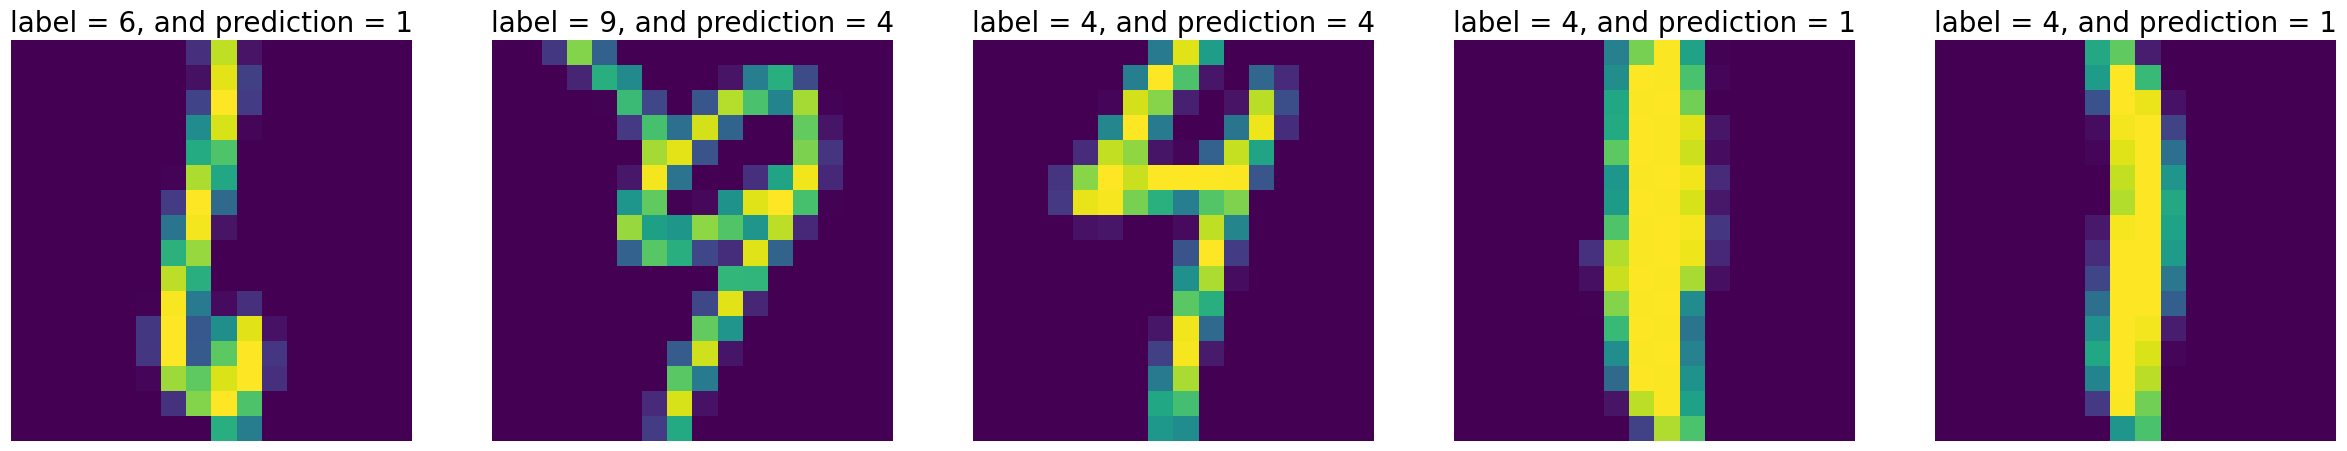

In [61]:
# visualising the 5 images

worst5 = np.argsort(Q4_data)[-5:]

plt.figure(figsize = (30,20))
for i,j in enumerate(worst5):
    plt.subplot(2,5,i+1)
    plt.imshow(x[j,:].reshape(16,16))
    plt.title('label = %.0f'%int(y[j]) + ', and prediction = %.0f'%int(y_pred[j]), fontsize=20)
    plt.axis('off')


## Q5

In [87]:
def Gaussian(p, q, k):
    p_norm = np.sum(p**2, axis =-1)
    q_norm = np.sum(q**2, axis =-1)
    return np.exp(-k*(p_norm[:, None] + q_norm[None,:]-2*(p @ q.T)))

In [88]:
min_iter = 7
GaussQ1_error = Q1(X, y, Gaussian, OvR, Error)
print(GaussQ1_error)

C:\Users\ZLiu\AppData\Local\Temp\ipykernel_13132\1114347381.py:18: RuntimeWarning: invalid value encountered in true_divide
  confusion_mtx = np.nan_to_num(confusion_mtx.T/np.sum(confusion_mtx, axis = 1)).T


[[0.000e+00 0.000e+00 6.108e+00 4.490e-01]
 [0.000e+00 0.000e+00 5.831e+00 4.250e-01]
 [1.000e-03 6.000e-03 5.097e+00 5.280e-01]
 [2.100e-02 1.700e-02 4.390e+00 4.050e-01]
 [3.000e-02 2.100e-02 3.487e+00 3.900e-01]
 [8.200e-02 4.600e-02 2.833e+00 3.490e-01]
 [2.500e-01 7.900e-02 3.215e+00 3.190e-01]]


In [92]:
GaussQ2_table = Q23(X, y, Gaussian, OvR, Error)

C:\Users\ZLiu\AppData\Local\Temp\ipykernel_13132\1114347381.py:18: RuntimeWarning: invalid value encountered in true_divide
  confusion_mtx = np.nan_to_num(confusion_mtx.T/np.sum(confusion_mtx, axis = 1)).T


In [93]:
Q5_error = np.array(GaussQ2_table[0])
Q5_error[:,-1] *= 100
print(Q5_error.round(4))

[[0.015625   2.6344086 ]
 [0.0078125  2.95698925]
 [0.015625   3.01075269]
 [0.0078125  4.19354839]
 [0.0078125  3.17204301]
 [0.015625   3.06451613]
 [0.015625   3.8172043 ]
 [0.015625   2.58064516]
 [0.015625   3.38709677]
 [0.015625   3.06451613]
 [0.015625   3.38709677]
 [0.015625   2.95698925]
 [0.015625   2.41935484]
 [0.015625   2.68817204]
 [0.015625   2.6344086 ]
 [0.015625   2.58064516]
 [0.015625   3.01075269]
 [0.015625   3.01075269]
 [0.015625   3.17204301]
 [0.015625   2.74193548]]


# Q6

In [19]:
min_iter = 3
Q6_I_data = Q1(X,y, Kd, OvO, Error_OvO)
print(Q6_I_data)

[[6.081 0.225 7.438 0.791]
 [2.233 0.173 4.422 0.64 ]
 [1.381 0.112 3.634 0.435]
 [1.113 0.165 3.723 0.518]
 [0.912 0.121 3.589 0.399]
 [0.818 0.092 3.508 0.433]
 [0.752 0.117 3.79  0.479]]


In [94]:
Q6_II_data = Q23(X,y, Kd, OvO, Error_OvO)
print(Q6_II_data.round(4))

[[6.      0.03817]
 [4.      0.03871]
 [5.      0.03118]
 [4.      0.03656]
 [4.      0.02849]
 [4.      0.0371 ]
 [5.      0.03441]
 [4.      0.03118]
 [4.      0.03118]
 [6.      0.03065]
 [6.      0.03495]
 [5.      0.03172]
 [3.      0.03172]
 [5.      0.03763]
 [5.      0.02581]
 [6.      0.03333]
 [6.      0.03441]
 [4.      0.03011]
 [4.      0.02742]
 [5.      0.03011]]
